Установим и импортируем необходимые библиотеки

In [2]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=8cd8c2a6305a03b52563ce3cb922e9f67fb8907d193854ac9a89b38d9d5b3faa
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [3]:
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.4 MB/s eta 0:00:00


In [67]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS
import re
import string
import emoji

from transformers import pipeline
from tqdm import tqdm

from collections import defaultdict

import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

import lightgbm

from numba import njit

from sklearn.metrics import ndcg_score

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils import np_utils

Прочитаем train и test данные в датафрейм и проведем небольшую предобработку для удобства работы и восприятия

In [5]:
train = pd.read_json(path_or_buf="/content/drive/MyDrive/ranking_train.jsonl", lines=True)

In [6]:
test = pd.read_json(path_or_buf='/content/drive/MyDrive/ranking_test.jsonl', lines=True)

In [7]:
new_index_size = train.shape[0] * 5
comments_count = len(train['comments'][0])

prepared_train = pd.DataFrame(data={
    'post_id': pd.Series(data=(i // comments_count for i in range(new_index_size))),
    'comment_id': pd.Series(data=(i for i in range(new_index_size))),
    'post_text': pd.Series(data=(train['text'][i // comments_count] for i in range(new_index_size))),
    'comment_text': pd.Series(
data=(train['comments'][i // comments_count][i % comments_count]['text'] for i in range(new_index_size))),
    'score': pd.Series(
data=(train['comments'][i // comments_count][i % comments_count]['score'] for i in range(new_index_size)))})

prepared_train.head(10)

,post_id,comment_id,post_text,comment_text,score
0,0,0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0
1,0,1,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1
2,0,2,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2
3,0,3,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3
4,0,4,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4
5,1,5,CBS acquires last.fm for $280m,It will be curious to see where this heads in ...,0
6,1,6,CBS acquires last.fm for $280m,Does this mean that there's now a big-name com...,1
7,1,7,CBS acquires last.fm for $280m,Also on BBC News: http://news.bbc.co.uk/1/low...,2
8,1,8,CBS acquires last.fm for $280m,I don't understand what they do that is worth ...,3
9,1,9,CBS acquires last.fm for $280m,sold out too cheaply. given their leadership p...,4


In [8]:
new_index_size = test.shape[0] * 5
comments_count = len(test['comments'][0])

prepared_test = pd.DataFrame(data={
    'post_id': pd.Series(data=(i // comments_count for i in range(new_index_size))),
    'comment_id': pd.Series(data=(i for i in range(new_index_size))),
    'post_text': pd.Series(data=(test['text'][i // comments_count] for i in range(new_index_size))),
    'comment_text': pd.Series(
data=(test['comments'][i // comments_count][i % comments_count]['text'] for i in range(new_index_size))),
    'score': pd.Series(
data=(test['comments'][i // comments_count][i % comments_count]['score'] for i in range(new_index_size)))})

prepared_test.head(10)

,post_id,comment_id,post_text,comment_text,score
0,0,0,"iOS 8.0.1 released, broken on iPhone 6 models,...",I&#x27;m still waiting for them to stabilize w...,None
1,0,1,"iOS 8.0.1 released, broken on iPhone 6 models,...","For those who upgraded, no need to do a restor...",None
2,0,2,"iOS 8.0.1 released, broken on iPhone 6 models,...",Upgraded shortly after it was released and suf...,None
3,0,3,"iOS 8.0.1 released, broken on iPhone 6 models,...",I think they were under a lot of pressure on t...,None
4,0,4,"iOS 8.0.1 released, broken on iPhone 6 models,...",Fix for those who already updated: http:&#x2F...,None
5,1,5,Ask HN: How do US HNers get their health insur...,Get it from your employer. It&#x27;s better an...,None
6,1,6,Ask HN: How do US HNers get their health insur...,As someone who moved from the UK to US under a...,None
7,1,7,Ask HN: How do US HNers get their health insur...,"I went to http:&#x2F;&#x2F;healthcare.gov, fil...",None
8,1,8,Ask HN: How do US HNers get their health insur...,"Full time employed, health insurance through m...",None
9,1,9,Ask HN: How do US HNers get their health insur...,Your options depend on where you live.I signed...,None


Посмотрим на размер датасетов

In [17]:
print('Training Set Shape = {}'.format(prepared_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(prepared_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(prepared_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(prepared_test.memory_usage().sum() / 1024**2))

Training Set Shape = (440535, 5)
Training Set Memory Usage = 16.81 MB
Test Set Shape = (70020, 5)
Test Set Memory Usage = 2.67 MB


## Пропущенные значения

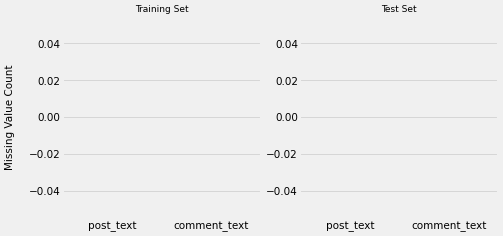

In [26]:
missing_cols = ['post_text', 'comment_text']

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), dpi=50)

sns.barplot(x=prepared_train[missing_cols].isnull().sum().index, y=prepared_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=prepared_test[missing_cols].isnull().sum().index, y=prepared_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

Как видно из приведенных графиков пропущенные значения отсутсвуют как в train выборке, так и в test выборке

## Мета-признаки

Из приведенных комментариев и текстов постов мы можем выделить следующие весьма полезные признаки, на основе которых в дальнейшем можно будет сделать некоторые выводы



*   word_count_post, word_count_comment - кол-во слов тексте поста и комментария
*   unique_word_count_post, unique_word_count_comment - кол-во уникальных слов в тексте поста и комментария
*   stop_word_count_post, stop_word_count_comment - кол-во стоп-слов в тексте поста и комментария
*   url_count_post, url_count_comment - кол-во URL в тексте поста и комментария
*   mean_word_length_post, mean_word_length_comment - среднее кол-во символов в словах текста поста и комментария
*   char_count_post, char_count_comment - кол-во символов в посте и комментарии
*   punctuation_count_post, punctuation_count_comment - кол-во знаков препинания в тексте поста и комментария
*   hashtag_count_post, hashtag_count_comment - кол-во хэштегов (#) в тексте поста и комментария
*   ment_count_post, ment_count_comment - кол-во упоминаний (@) в тексте
*   emojis_count_post, emojis_count_comment - кол-во смайликов в тексте поста и комментария 

In [9]:
# word_count_post, word_count_comment
prepared_train['word_count_post'] = prepared_train['post_text'].apply(lambda x: len(str(x).split()))
prepared_train['word_count_comment'] = prepared_train['comment_text'].apply(lambda x: len(str(x).split()))
prepared_test['word_count_post'] = prepared_test['post_text'].apply(lambda x: len(str(x).split()))
prepared_test['word_count_comment'] = prepared_test['comment_text'].apply(lambda x: len(str(x).split()))

In [10]:
# unique_word_count_post, unique_word_count_comment
prepared_train['unique_word_count_post'] = prepared_train['post_text'].apply(lambda x: len(set(str(x).split())))
prepared_train['unique_word_count_comment'] = prepared_train['comment_text'].apply(lambda x: len(set(str(x).split())))
prepared_test['unique_word_count_post'] = prepared_test['post_text'].apply(lambda x: len(set(str(x).split())))
prepared_test['unique_word_count_comment'] = prepared_test['comment_text'].apply(lambda x: len(set(str(x).split())))

In [11]:
# stop_word_count_post, stop_word_count_comment
prepared_train['stop_word_count_post'] = prepared_train['post_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
prepared_train['stop_word_count_comment'] = prepared_train['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
prepared_test['stop_word_count_post'] = prepared_test['post_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
prepared_test['stop_word_count_comment'] = prepared_test['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [12]:
# url_count_post, url_count_comment
prepared_train['url_count_post'] = prepared_train['post_text'].apply(lambda x: len([w for w in str(x).lower().split() if re.match(r'(https?://[\S]+)', w) != None]))
prepared_train['url_count_comment'] = prepared_train['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if re.match(r'(https?://[\S]+)', w) != None]))
prepared_test['url_count_post'] = prepared_test['post_text'].apply(lambda x: len([w for w in str(x).lower().split() if re.match(r'(https?://[\S]+)', w) != None]))
prepared_test['url_count_comment'] = prepared_test['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() if re.match(r'(https?://[\S]+)', w) != None]))

In [13]:
# mean_word_length_post, mean_word_length_comment
prepared_train['mean_word_length_post'] = prepared_train['post_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
prepared_train['mean_word_length_comment'] = prepared_train['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
prepared_test['mean_word_length_post'] = prepared_test['post_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
prepared_test['mean_word_length_comment'] = prepared_test['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [14]:
# char_count_post, char_count_comment
prepared_train['char_count_post'] = prepared_train['post_text'].apply(lambda x: len(str(x)))
prepared_train['char_count_comment'] = prepared_train['comment_text'].apply(lambda x: len(str(x)))
prepared_test['char_count_post'] = prepared_test['post_text'].apply(lambda x: len(str(x)))
prepared_test['char_count_comment'] = prepared_test['comment_text'].apply(lambda x: len(str(x)))

In [15]:
# punctuation_count_post, punctuation_count_comment
prepared_train['punctuation_count_post'] = prepared_train['post_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
prepared_train['punctuation_count_comment'] = prepared_train['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
prepared_test['punctuation_count_post'] = prepared_test['post_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
prepared_test['punctuation_count_comment'] = prepared_test['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [16]:
# hashtag_count_post, hashtag_count_comment
prepared_train['hashtag_count_post'] = prepared_train['post_text'].apply(lambda x: len([c for c in str(x) if c == '#']))
prepared_train['hashtag_count_comment'] = prepared_train['comment_text'].apply(lambda x: len([c for c in str(x) if c == '#']))
prepared_test['hashtag_count_post'] = prepared_test['post_text'].apply(lambda x: len([c for c in str(x) if c == '#']))
prepared_test['hashtag_count_comment'] = prepared_test['comment_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

In [17]:
# mention_count_post, mention_count_comment
prepared_train['mention_count_post'] = prepared_train['post_text'].apply(lambda x: len([c for c in str(x) if c == '@']))
prepared_train['mention_count_comment'] = prepared_train['comment_text'].apply(lambda x: len([c for c in str(x) if c == '@']))
prepared_test['mention_count_post'] = prepared_test['post_text'].apply(lambda x: len([c for c in str(x) if c == '@']))
prepared_test['mention_count_comment'] = prepared_test['comment_text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [18]:
# emojis_count_post, emojis_count_comment
prepared_train['emojis_count_post'] = prepared_train['post_text'].apply(lambda x: emoji.emoji_count(x))
prepared_train['emojis_count_comment'] = prepared_train['comment_text'].apply(lambda x: emoji.emoji_count(x))
prepared_test['emojis_count_post'] = prepared_test['post_text'].apply(lambda x: emoji.emoji_count(x))
prepared_test['emojis_count_comment'] = prepared_test['comment_text'].apply(lambda x: emoji.emoji_count(x))

### Определим тональность текстов и используем её в качестве мета-фич

В данном блоке будут показаны возможные варианты дополнительного выделения фич с помощью готовых обученных моделей библиотеки HuggingFace. Наша команда же этого делать не будет, так не обладает достаточными вычислительными ресурсами для выделения данных фич, попросту займет очень много времени

Создаём пайплайн для решения задачи обработки естественного языка

In [70]:
classifier = pipeline('text-classification', model='ProsusAI/finbert')

Используем пайплайн для определения тональности текста

In [71]:
results = classifier("There should be our dataset")

## Посмотрим на распределение фич

### Построим гистограммы для фич комментов

Заметим небольшие закономерности, такие как:


*   Меньший по кол-ву слов комментарий вероятнее всего станет популярнее комментария, с большим кол-вом слов  
*   Следует избегать большого числа стоп-слов, это делает комментарий менее популярным



<ipython-input-63-c1fee6eb4136>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prepared_train.loc[POPULAR_0][feature], label='Popular 0', ax=axes[i], color='black', kde=False)
<ipython-input-63-c1fee6eb4136>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prepared_train.loc[POPULAR_1][featu

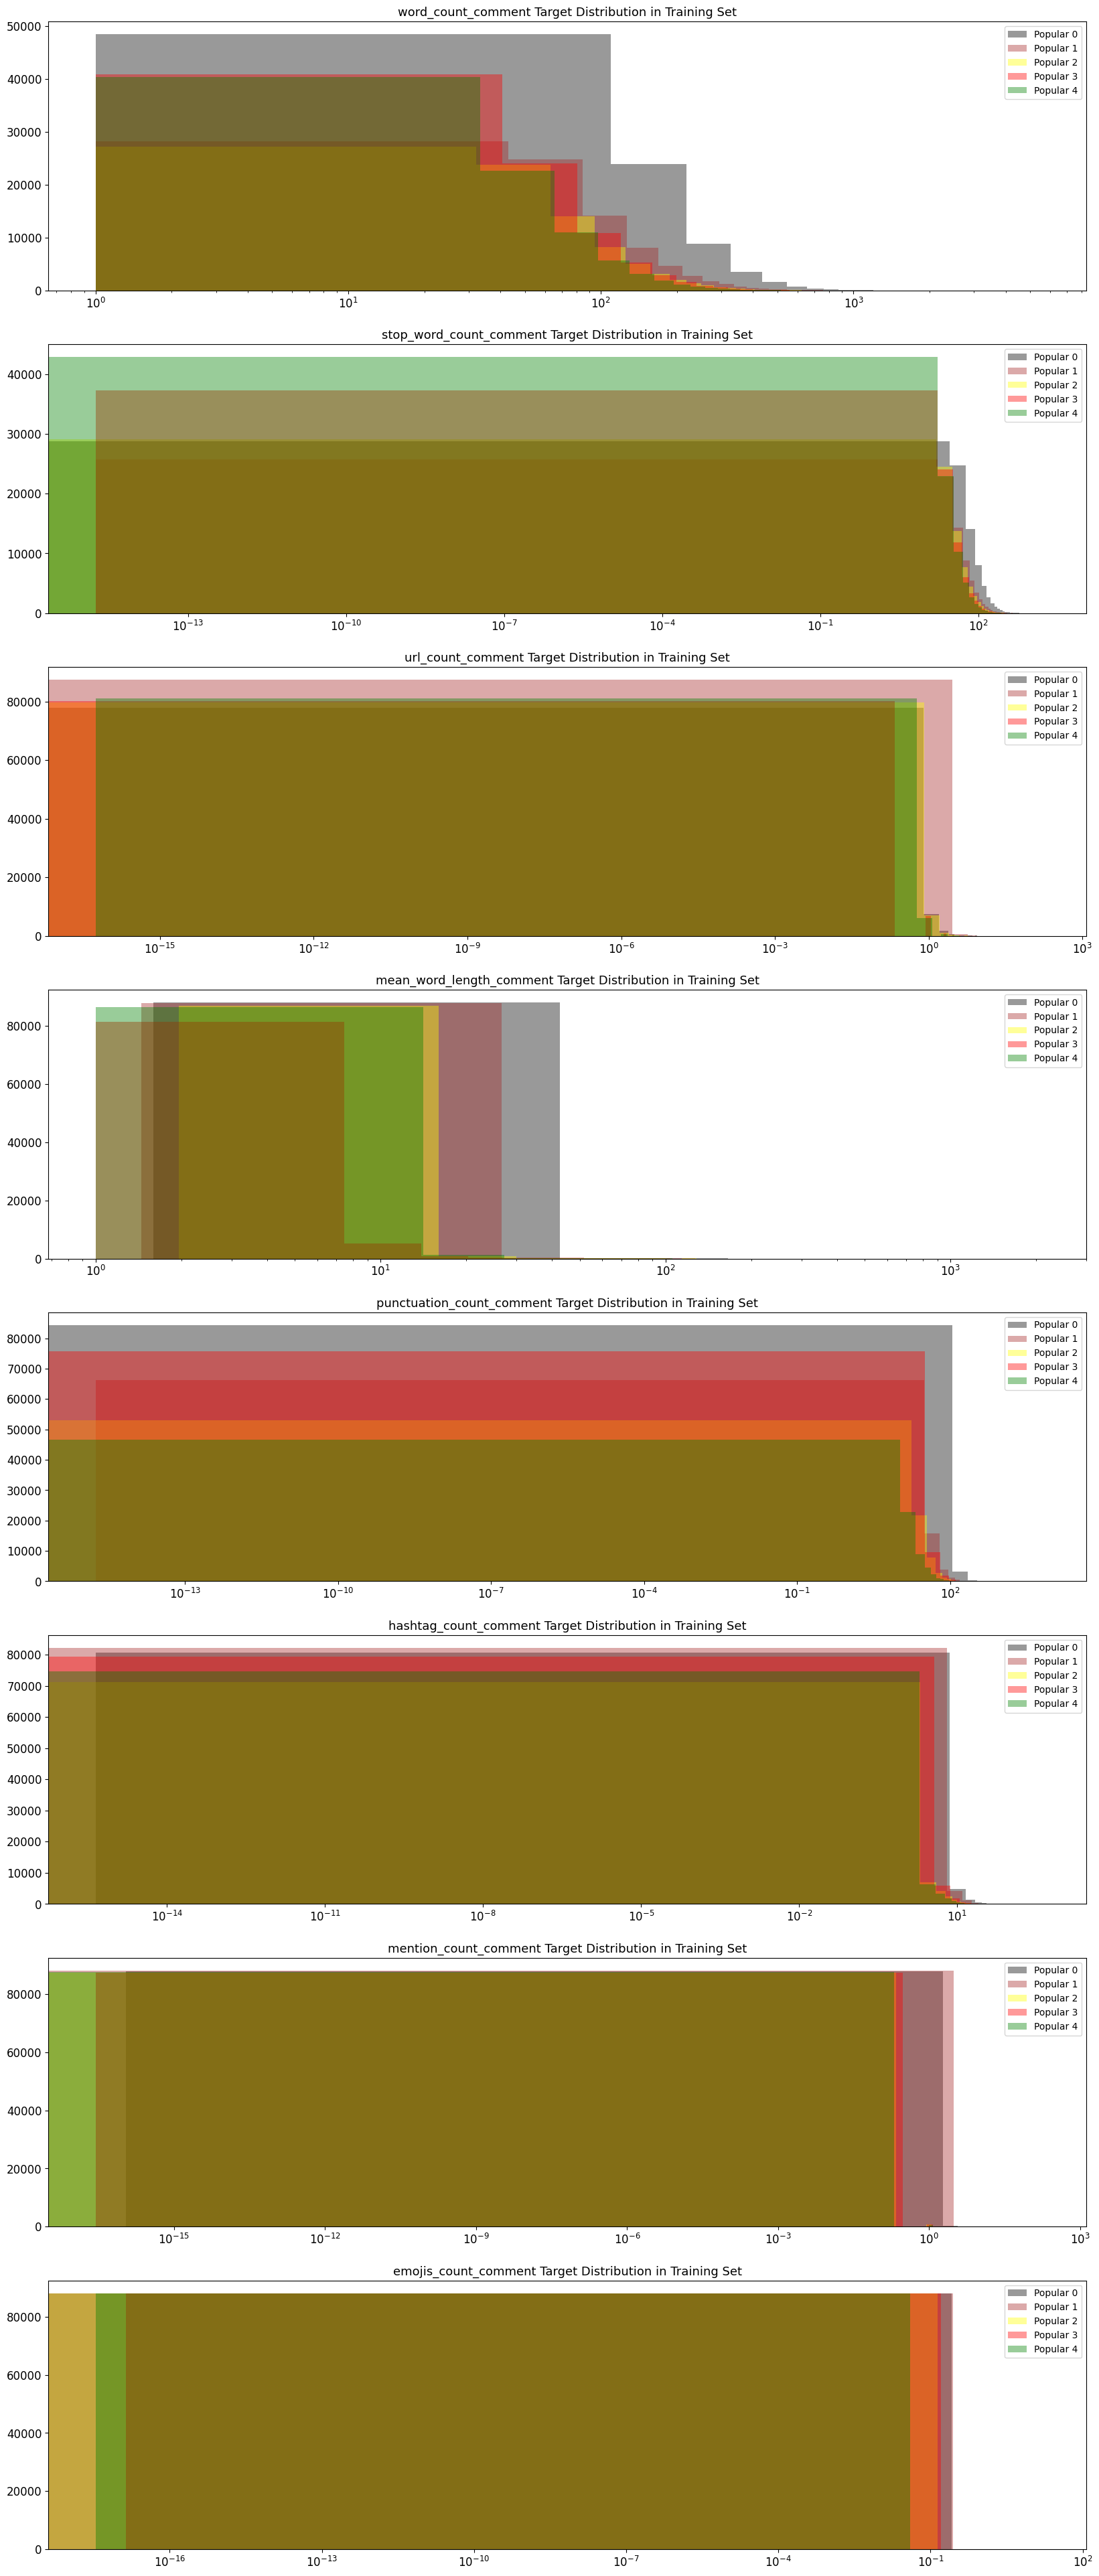

In [63]:
METAFEATURES = ['word_count_comment', 'stop_word_count_comment', 'url_count_comment', 'mean_word_length_comment',
                'punctuation_count_comment', 'hashtag_count_comment', 'mention_count_comment', 'emojis_count_comment']
POPULAR_0 = prepared_train['score'] == 0
POPULAR_1 = prepared_train['score'] == 1
POPULAR_2 = prepared_train['score'] == 2
POPULAR_3 = prepared_train['score'] == 3
POPULAR_4 = prepared_train['score'] == 4

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(prepared_train.loc[POPULAR_0][feature], label='Popular 0', ax=axes[i], color='black', kde=False)
    sns.distplot(prepared_train.loc[POPULAR_1][feature], label='Popular 1', ax=axes[i], color='brown', kde=False)
    sns.distplot(prepared_train.loc[POPULAR_2][feature], label='Popular 2', ax=axes[i], color='yellow', kde=False)
    sns.distplot(prepared_train.loc[POPULAR_3][feature], label='Popular 3', ax=axes[i], color='red', kde=False)
    sns.distplot(prepared_train.loc[POPULAR_4][feature], label='Popular 4', ax=axes[i], color='green', kde=False)

    axes[i].semilogx()
    
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
    axes[i].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)

plt.show()

### Построим Box Plot диаграммы

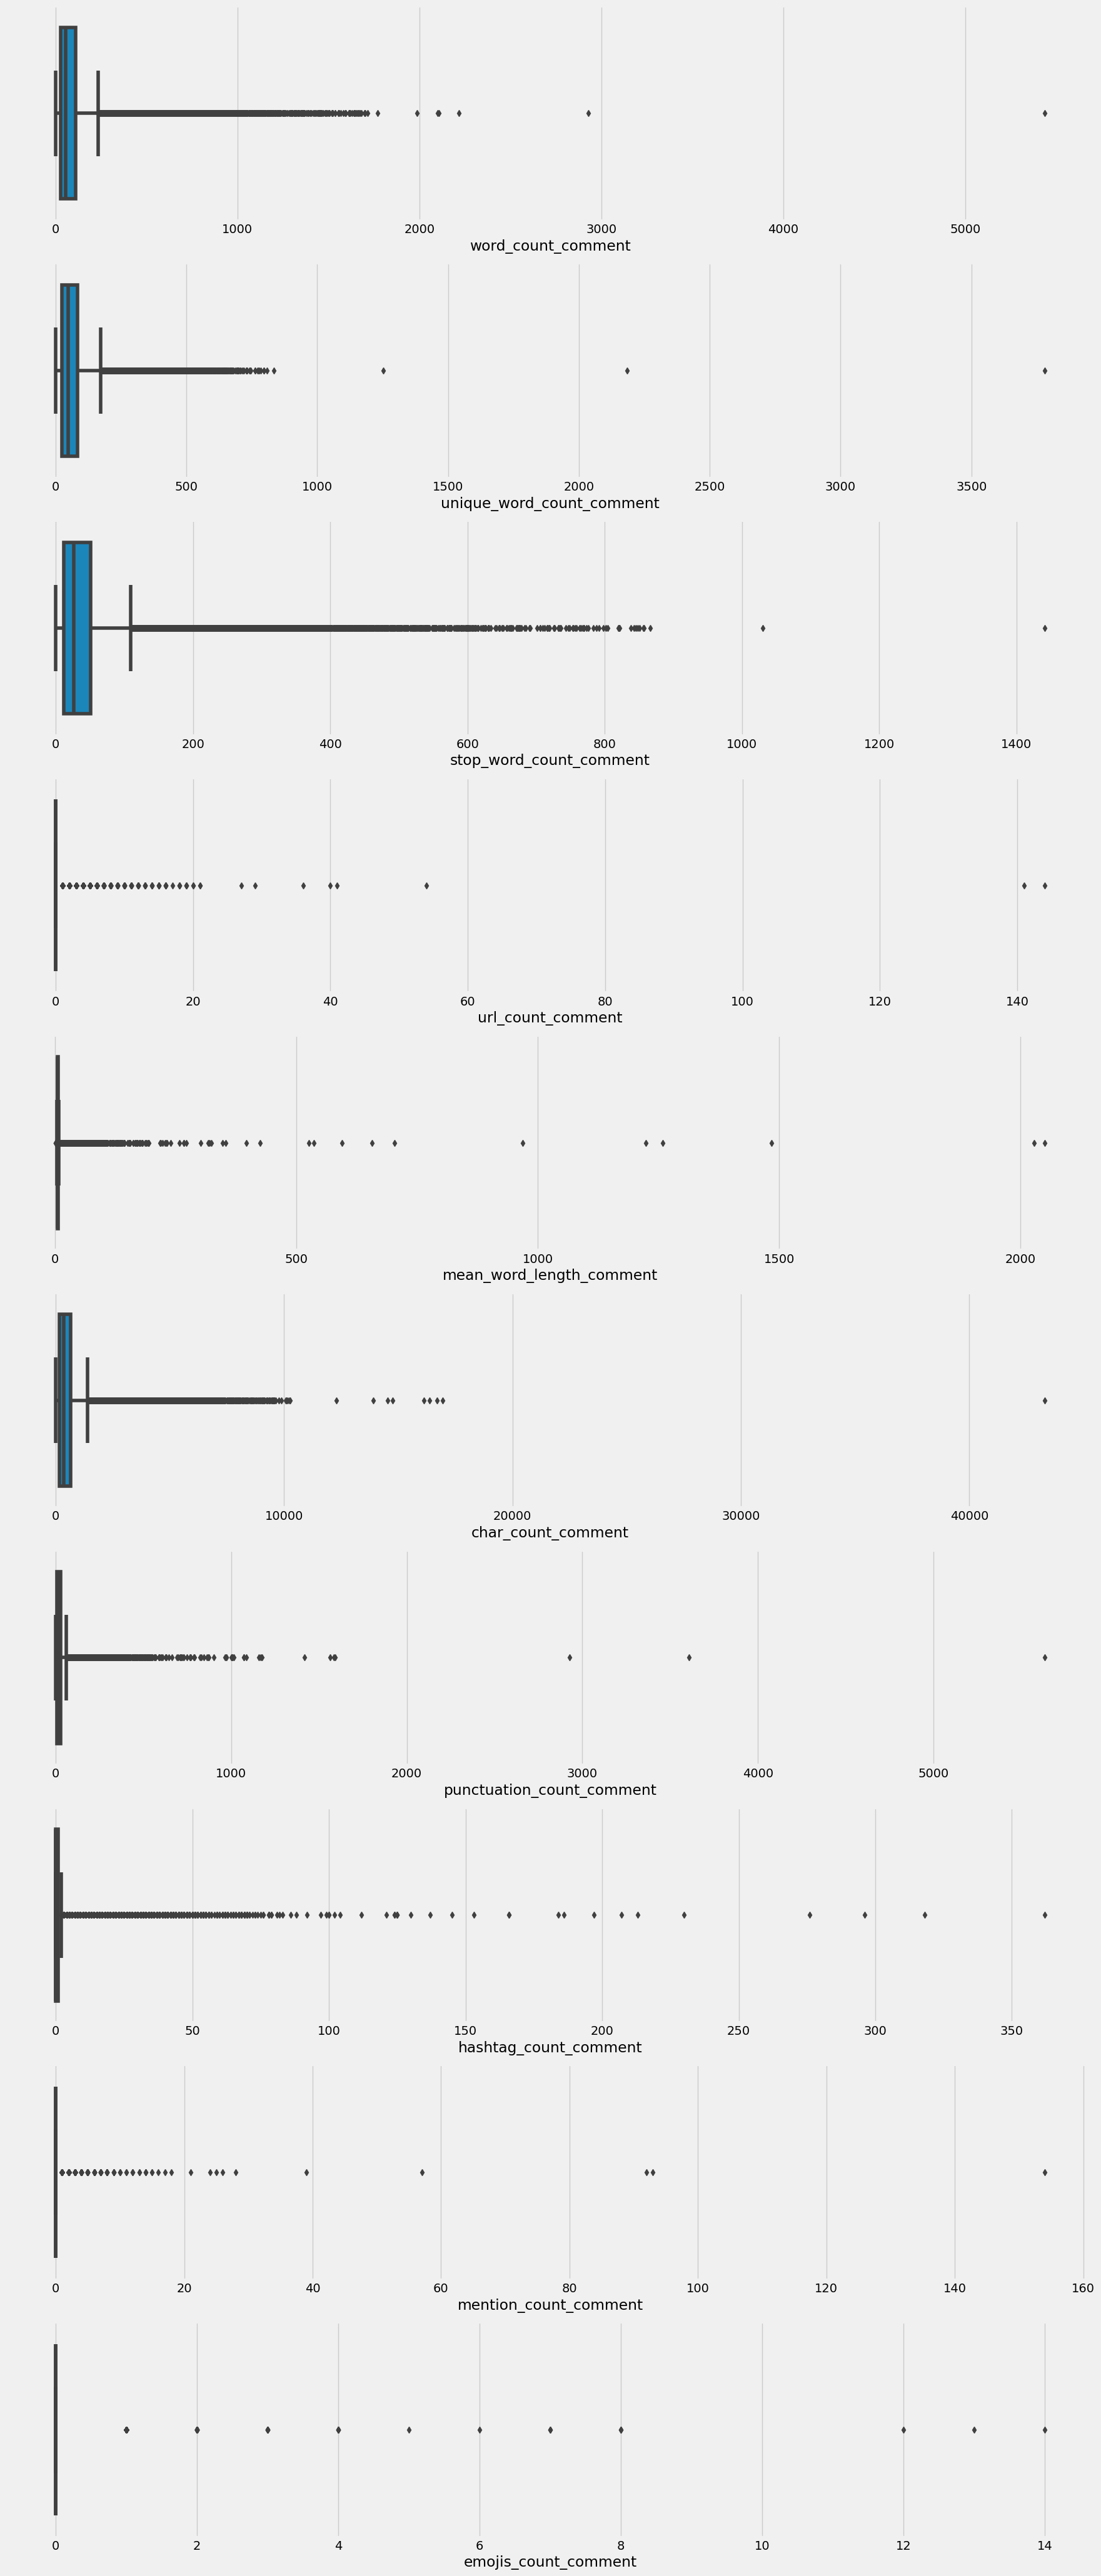

In [91]:
fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.boxplot(data=prepared_train, x=feature, ax=axes[i])

plt.show()

### Посмотрим на матрицу корреляции

<Axes: >

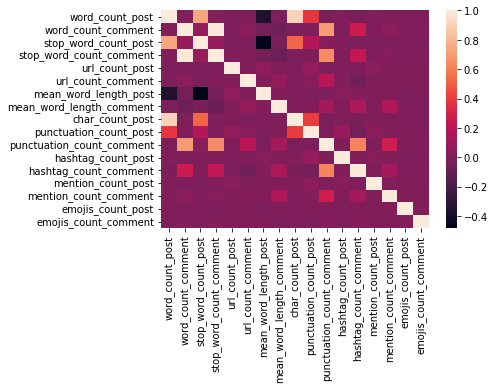

In [151]:
METAFEATURES = ['word_count_post', 'word_count_comment', 'stop_word_count_post', 'stop_word_count_comment',
                'url_count_post', 'url_count_comment', 'mean_word_length_post', 'mean_word_length_comment', 'char_count_post',
                'punctuation_count_post', 'punctuation_count_comment', 'hashtag_count_post', 'hashtag_count_comment', 'mention_count_post', 'mention_count_comment',
                'emojis_count_post', 'emojis_count_comment']

corr_matrix = prepared_train[METAFEATURES].corr()
sns.heatmap(corr_matrix)

Как мы видим из матрицы корреляции, некоторые признаки довольно сильно коррелируют между собой, поэтому некоторые из них можно опустить.

Удалим следующие признаки:

*   unique_word_count_post
*   unique_word_count_comment
*   char_count_comment


In [19]:
prepared_train = prepared_train.drop(labels=['unique_word_count_post', 'unique_word_count_comment', 'char_count_comment'], axis=1)

In [20]:
prepared_test = prepared_test.drop(labels=['unique_word_count_post', 'unique_word_count_comment', 'char_count_comment'], axis=1)

### Построим Pair Plot

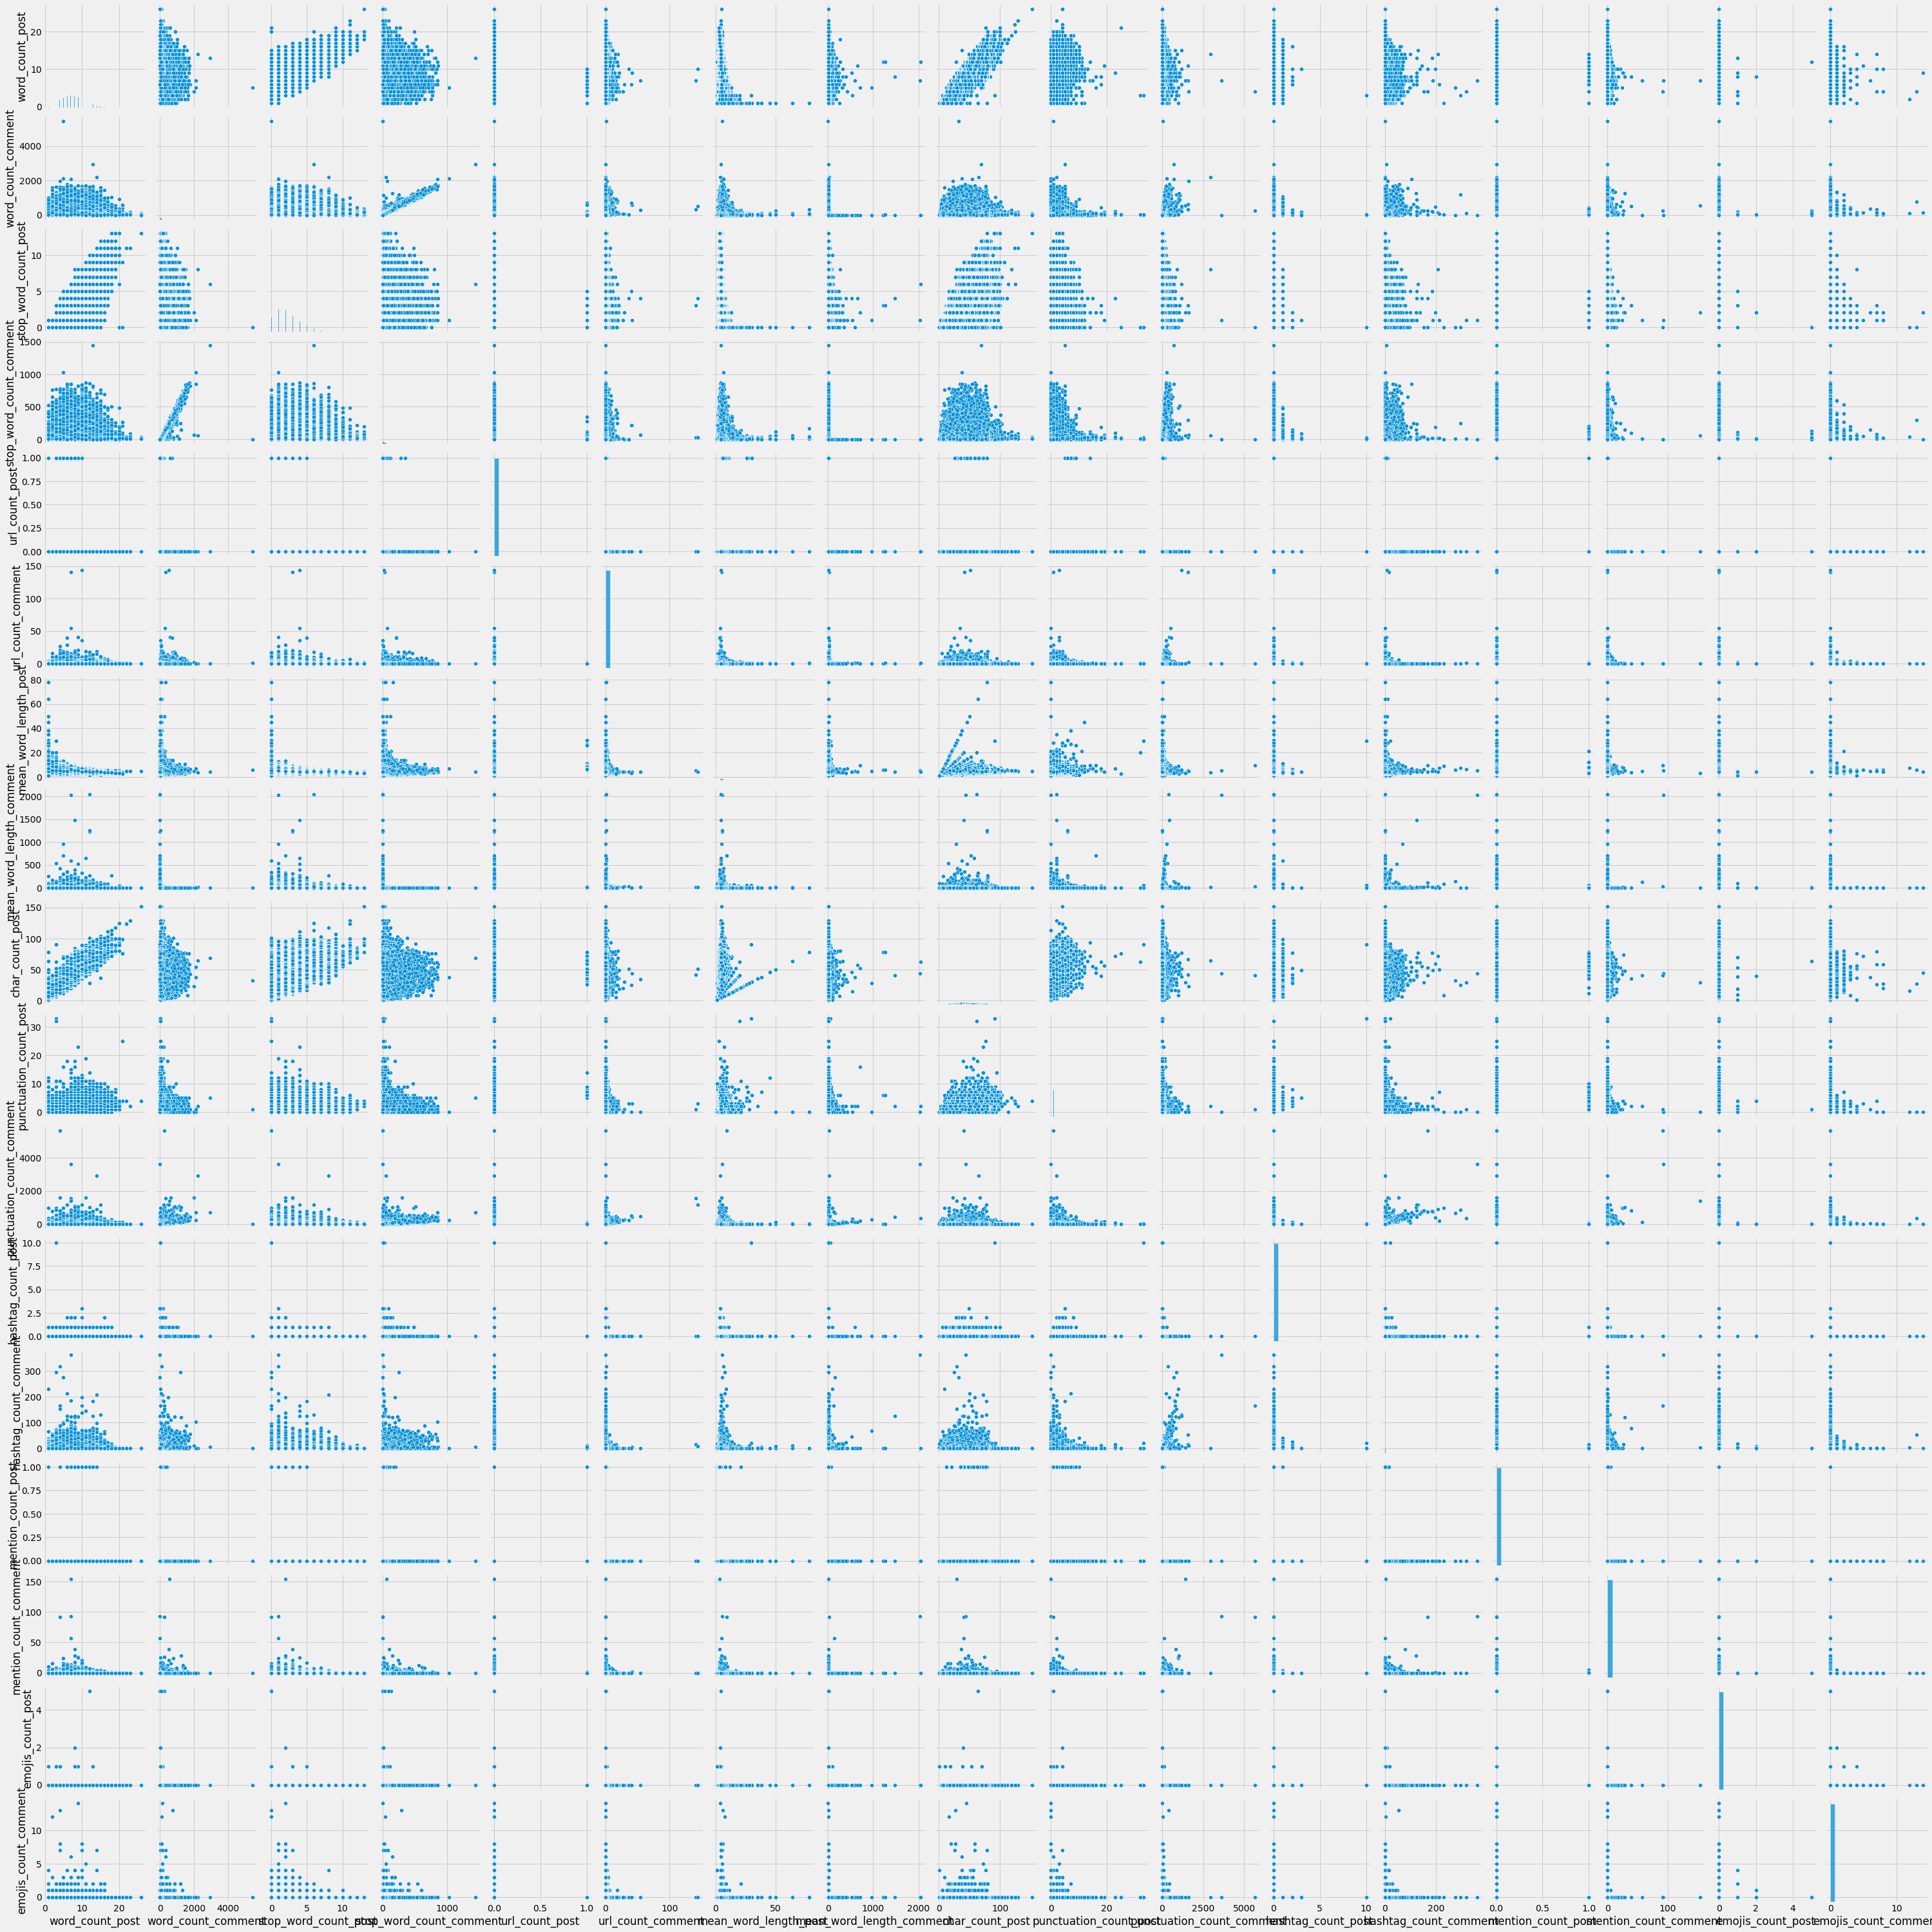

In [99]:
METAFEATURES = ['word_count_post', 'word_count_comment', 'stop_word_count_post', 'stop_word_count_comment',
                'url_count_post', 'url_count_comment', 'mean_word_length_post', 'mean_word_length_comment', 'char_count_post',
                'punctuation_count_post', 'punctuation_count_comment', 'hashtag_count_post', 'hashtag_count_comment', 'mention_count_post', 'mention_count_comment',
                'emojis_count_post', 'emojis_count_comment']

# `pairplot()` may become very slow with the SVG format
%config InlineBackend.figure_format = 'png'
sns.pairplot(prepared_train[METAFEATURES]);

Разделим текст на N-grams и посмотрим на частоту встречаемости

In [21]:
POPULAR_0 = prepared_train['score'] == 0
POPULAR_1 = prepared_train['score'] == 1
POPULAR_2 = prepared_train['score'] == 2
POPULAR_3 = prepared_train['score'] == 3
POPULAR_4 = prepared_train['score'] == 4

In [153]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
popular_0_unigrams = defaultdict(int)
popular_1_unigrams = defaultdict(int)
popular_2_unigrams = defaultdict(int)
popular_3_unigrams = defaultdict(int)
popular_4_unigrams = defaultdict(int)

for text in prepared_train[POPULAR_0]['comment_text']:
    for word in generate_ngrams(text):
        popular_0_unigrams[word] += 1
        
for text in prepared_train[POPULAR_1]['comment_text']:
    for word in generate_ngrams(text):
        popular_1_unigrams[word] += 1

for text in prepared_train[POPULAR_2]['comment_text']:
    for word in generate_ngrams(text):
        popular_2_unigrams[word] += 1  

for text in prepared_train[POPULAR_3]['comment_text']:
    for word in generate_ngrams(text):
        popular_3_unigrams[word] += 1  

for text in prepared_train[POPULAR_4]['comment_text']:
    for word in generate_ngrams(text):
        popular_4_unigrams[word] += 1  
        
df_popular_0_unigrams = pd.DataFrame(sorted(popular_0_unigrams.items(), key=lambda x: x[1])[::-1])
df_popular_1_unigrams = pd.DataFrame(sorted(popular_1_unigrams.items(), key=lambda x: x[1])[::-1])
df_popular_2_unigrams = pd.DataFrame(sorted(popular_2_unigrams.items(), key=lambda x: x[1])[::-1])
df_popular_3_unigrams = pd.DataFrame(sorted(popular_3_unigrams.items(), key=lambda x: x[1])[::-1])
df_popular_4_unigrams = pd.DataFrame(sorted(popular_4_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
popular_0_bigrams = defaultdict(int)
popular_1_bigrams = defaultdict(int)
popular_2_bigrams = defaultdict(int)
popular_3_bigrams = defaultdict(int)
popular_4_bigrams = defaultdict(int)

for text in prepared_train[POPULAR_0]['comment_text']:
    for word in generate_ngrams(text, n_gram=2):
        popular_0_bigrams[word] += 1
        
for text in prepared_train[POPULAR_1]['comment_text']:
    for word in generate_ngrams(text, n_gram=2):
        popular_1_bigrams[word] += 1

for text in prepared_train[POPULAR_2]['comment_text']:
    for word in generate_ngrams(text, n_gram=2):
        popular_2_bigrams[word] += 1  

for text in prepared_train[POPULAR_3]['comment_text']:
    for word in generate_ngrams(text, n_gram=2):
        popular_3_bigrams[word] += 1  

for text in prepared_train[POPULAR_4]['comment_text']:
    for word in generate_ngrams(text, n_gram=2):
        popular_4_bigrams[word] += 1  
        
df_popular_0_bigrams = pd.DataFrame(sorted(popular_0_bigrams.items(), key=lambda x: x[1])[::-1])
df_popular_1_bigrams = pd.DataFrame(sorted(popular_1_bigrams.items(), key=lambda x: x[1])[::-1])
df_popular_2_bigrams = pd.DataFrame(sorted(popular_2_bigrams.items(), key=lambda x: x[1])[::-1])
df_popular_3_bigrams = pd.DataFrame(sorted(popular_3_bigrams.items(), key=lambda x: x[1])[::-1])
df_popular_4_bigrams = pd.DataFrame(sorted(popular_4_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
popular_0_trigrams = defaultdict(int)
popular_1_trigrams = defaultdict(int)
popular_2_trigrams = defaultdict(int)
popular_3_trigrams = defaultdict(int)
popular_4_trigrams = defaultdict(int)

for text in prepared_train[POPULAR_0]['comment_text']:
    for word in generate_ngrams(text, n_gram=3):
        popular_0_trigrams[word] += 1
        
for text in prepared_train[POPULAR_1]['comment_text']:
    for word in generate_ngrams(text, n_gram=3):
        popular_1_trigrams[word] += 1

for text in prepared_train[POPULAR_2]['comment_text']:
    for word in generate_ngrams(text, n_gram=3):
        popular_2_trigrams[word] += 1  

for text in prepared_train[POPULAR_3]['comment_text']:
    for word in generate_ngrams(text, n_gram=3):
        popular_3_trigrams[word] += 1  

for text in prepared_train[POPULAR_4]['comment_text']:
    for word in generate_ngrams(text, n_gram=3):
        popular_4_trigrams[word] += 1  
        
df_popular_0_trigrams = pd.DataFrame(sorted(popular_0_trigrams.items(), key=lambda x: x[1])[::-1])
df_popular_1_trigrams = pd.DataFrame(sorted(popular_1_trigrams.items(), key=lambda x: x[1])[::-1])
df_popular_2_trigrams = pd.DataFrame(sorted(popular_2_trigrams.items(), key=lambda x: x[1])[::-1])
df_popular_3_trigrams = pd.DataFrame(sorted(popular_3_trigrams.items(), key=lambda x: x[1])[::-1])
df_popular_4_trigrams = pd.DataFrame(sorted(popular_4_trigrams.items(), key=lambda x: x[1])[::-1])

#### Unigrams

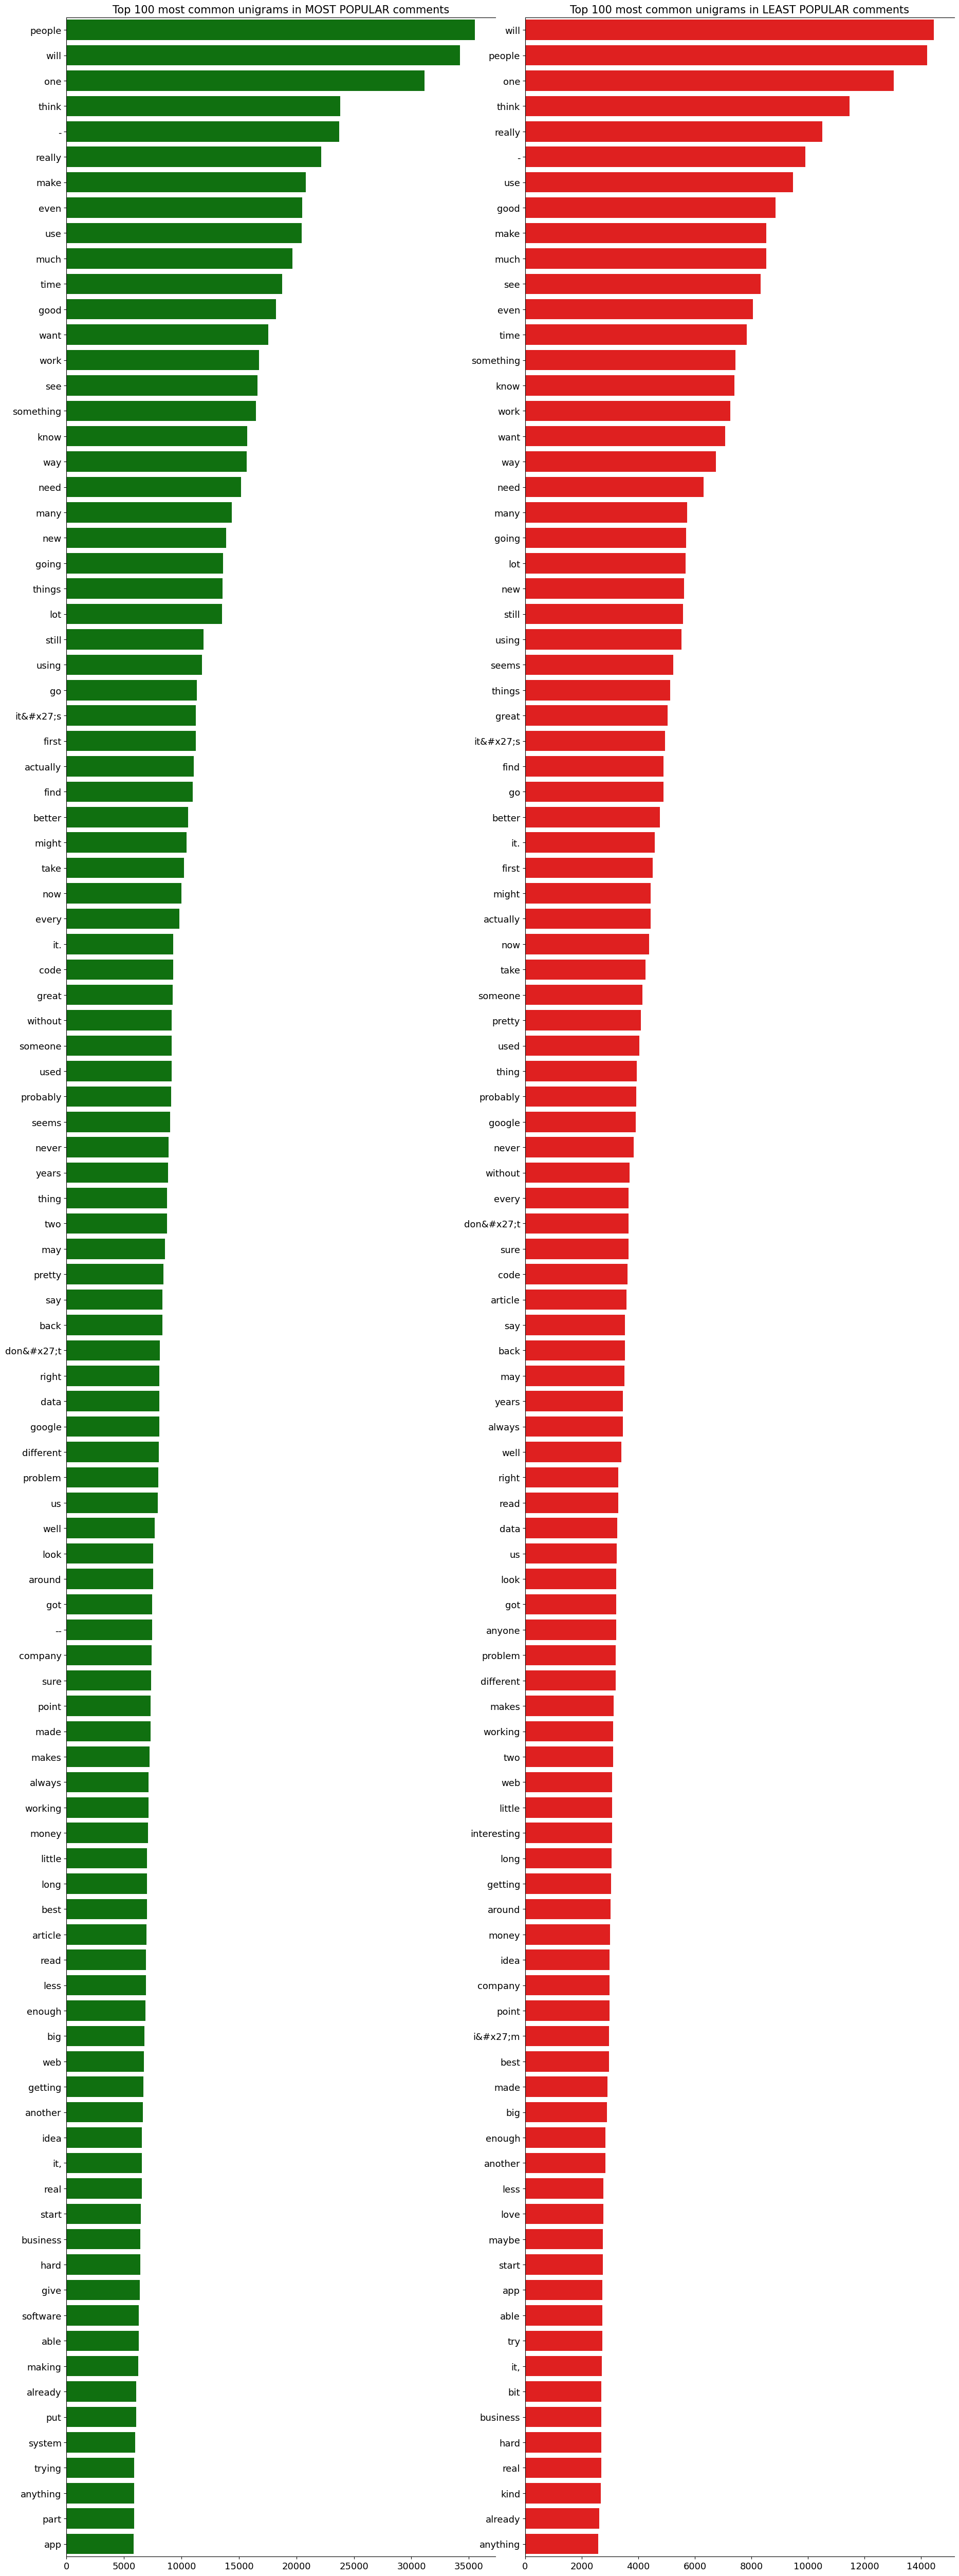

In [154]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_popular_0_unigrams[0].values[:N], x=df_popular_0_unigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_popular_4_unigrams[0].values[:N], x=df_popular_4_unigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in MOST POPULAR comments', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in LEAST POPULAR comments', fontsize=15)

plt.show()

In [31]:
alues_popular = set(df_popular_0_unigrams[0].values[:N])
values_unpopular = set(df_popular_4_unigrams[0].values[:N])

Наиболее популярные уникальные слова встречающиеся в топ 100

In [32]:
values_popular - values_unpopular

{'--', 'give', 'making', 'part', 'put', 'software', 'system', 'trying'}

Наименее популярные уникальные слова встречающиеся в топ 100

In [33]:
values_unpopular - values_popular

{'anyone', 'bit', 'i&#x27;m', 'interesting', 'kind', 'love', 'maybe', 'try'}

#### Bigrams

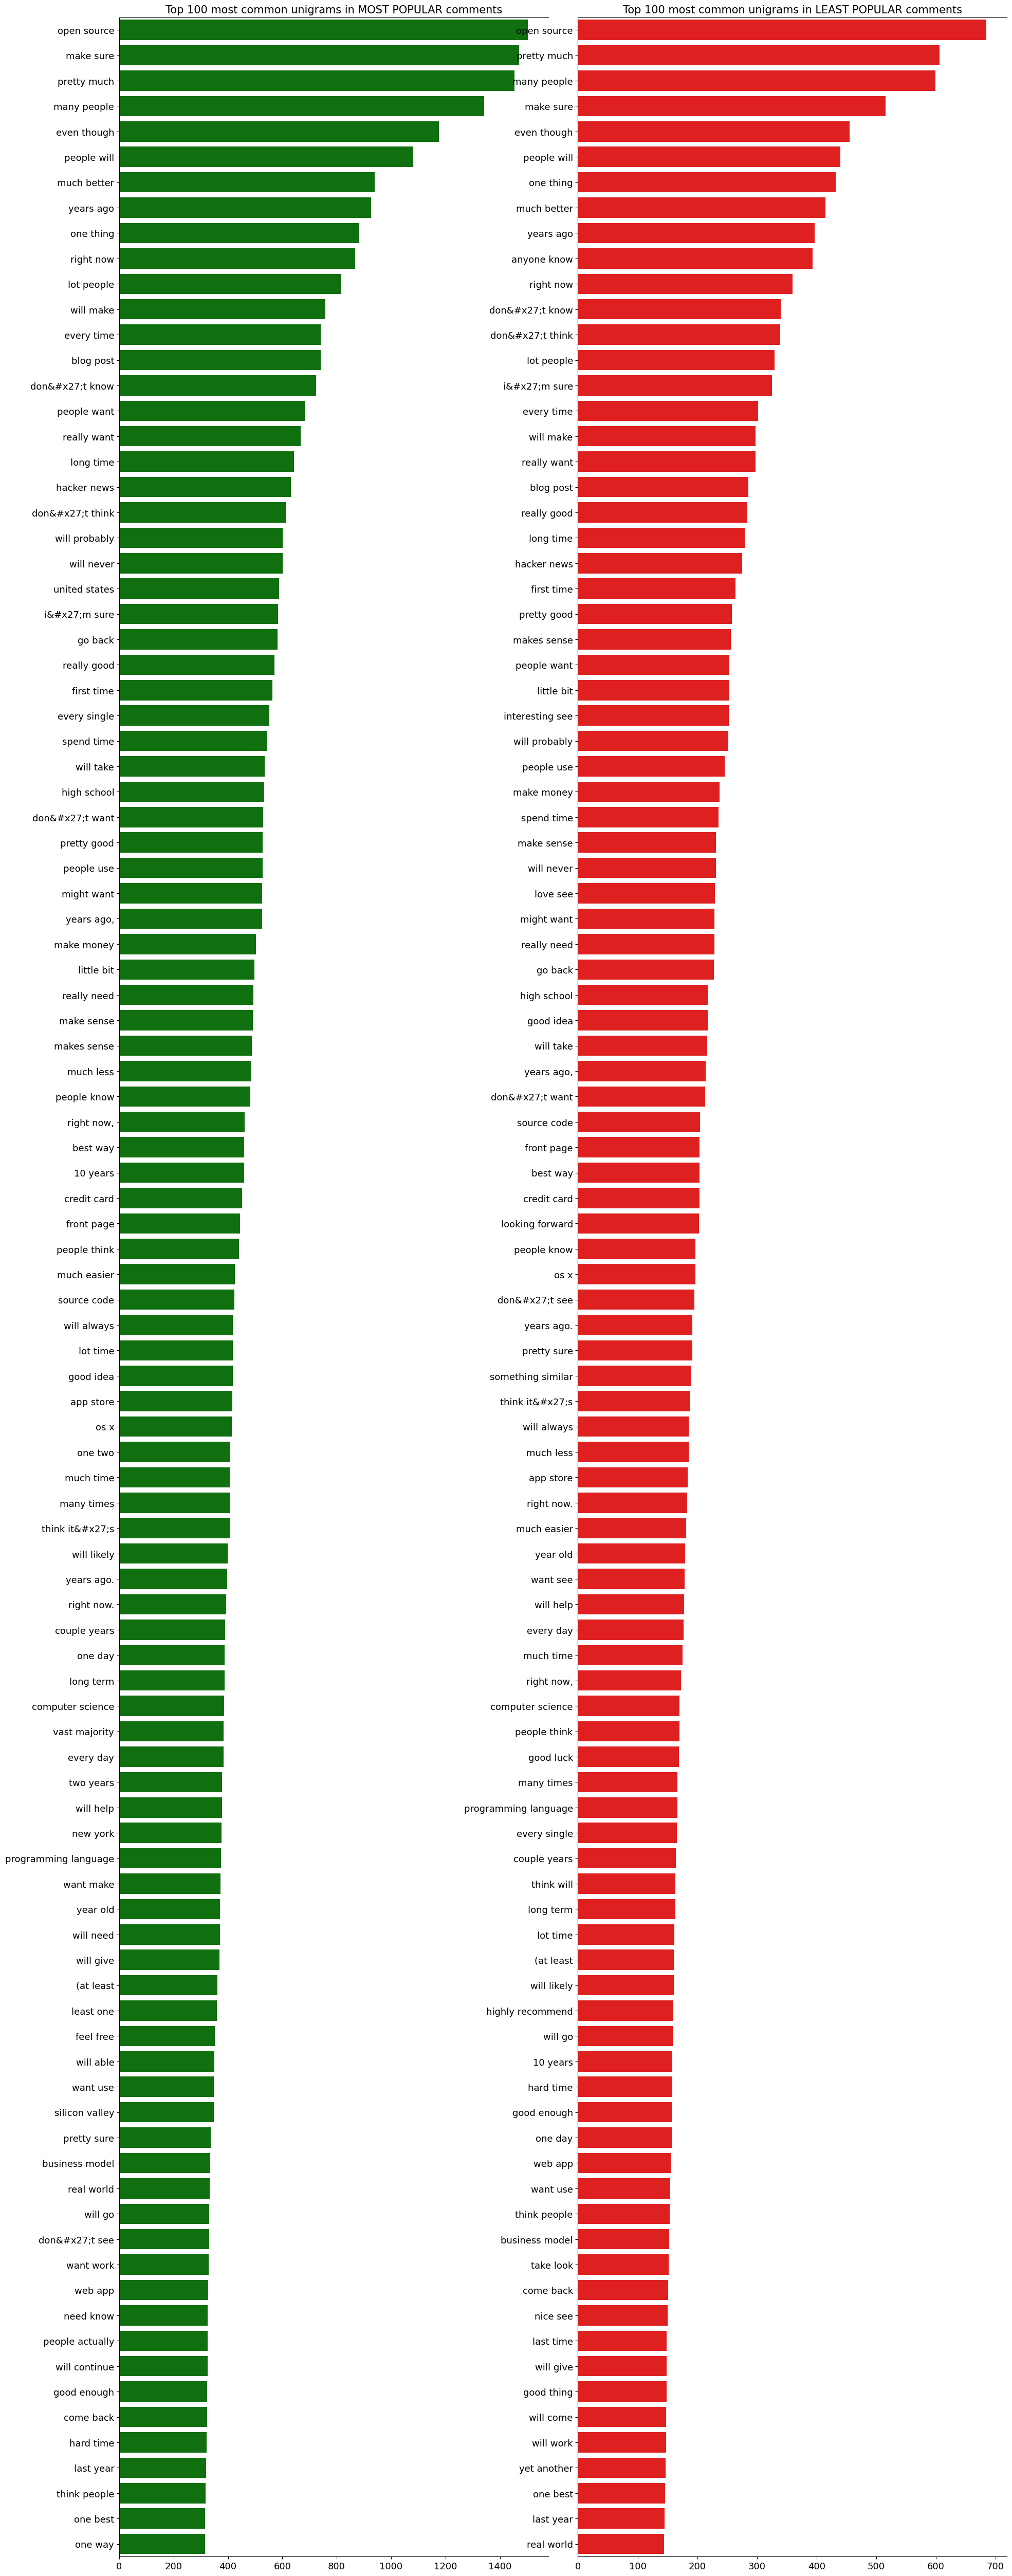

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_popular_0_bigrams[0].values[:N], x=df_popular_0_bigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_popular_4_bigrams[0].values[:N], x=df_popular_4_bigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in MOST POPULAR comments', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in LEAST POPULAR comments', fontsize=15)

plt.show()

In [34]:
values_popular = set(df_popular_0_bigrams[0].values[:N])
values_unpopular = set(df_popular_4_bigrams[0].values[:N])

Наиболее популярные уникальные слова встречающиеся в топ 100

In [35]:
values_popular - values_unpopular

{'feel free',
 'least one',
 'need know',
 'new york',
 'one two',
 'one way',
 'people actually',
 'silicon valley',
 'two years',
 'united states',
 'vast majority',
 'want make',
 'want work',
 'will able',
 'will continue',
 'will need'}

Наименее популярные уникальные слова встречающиеся в топ 100

In [36]:
values_unpopular - values_popular

{'anyone know',
 'good luck',
 'good thing',
 'highly recommend',
 'interesting see',
 'last time',
 'looking forward',
 'love see',
 'nice see',
 'something similar',
 'take look',
 'think will',
 'want see',
 'will come',
 'will work',
 'yet another'}

#### Trigrams

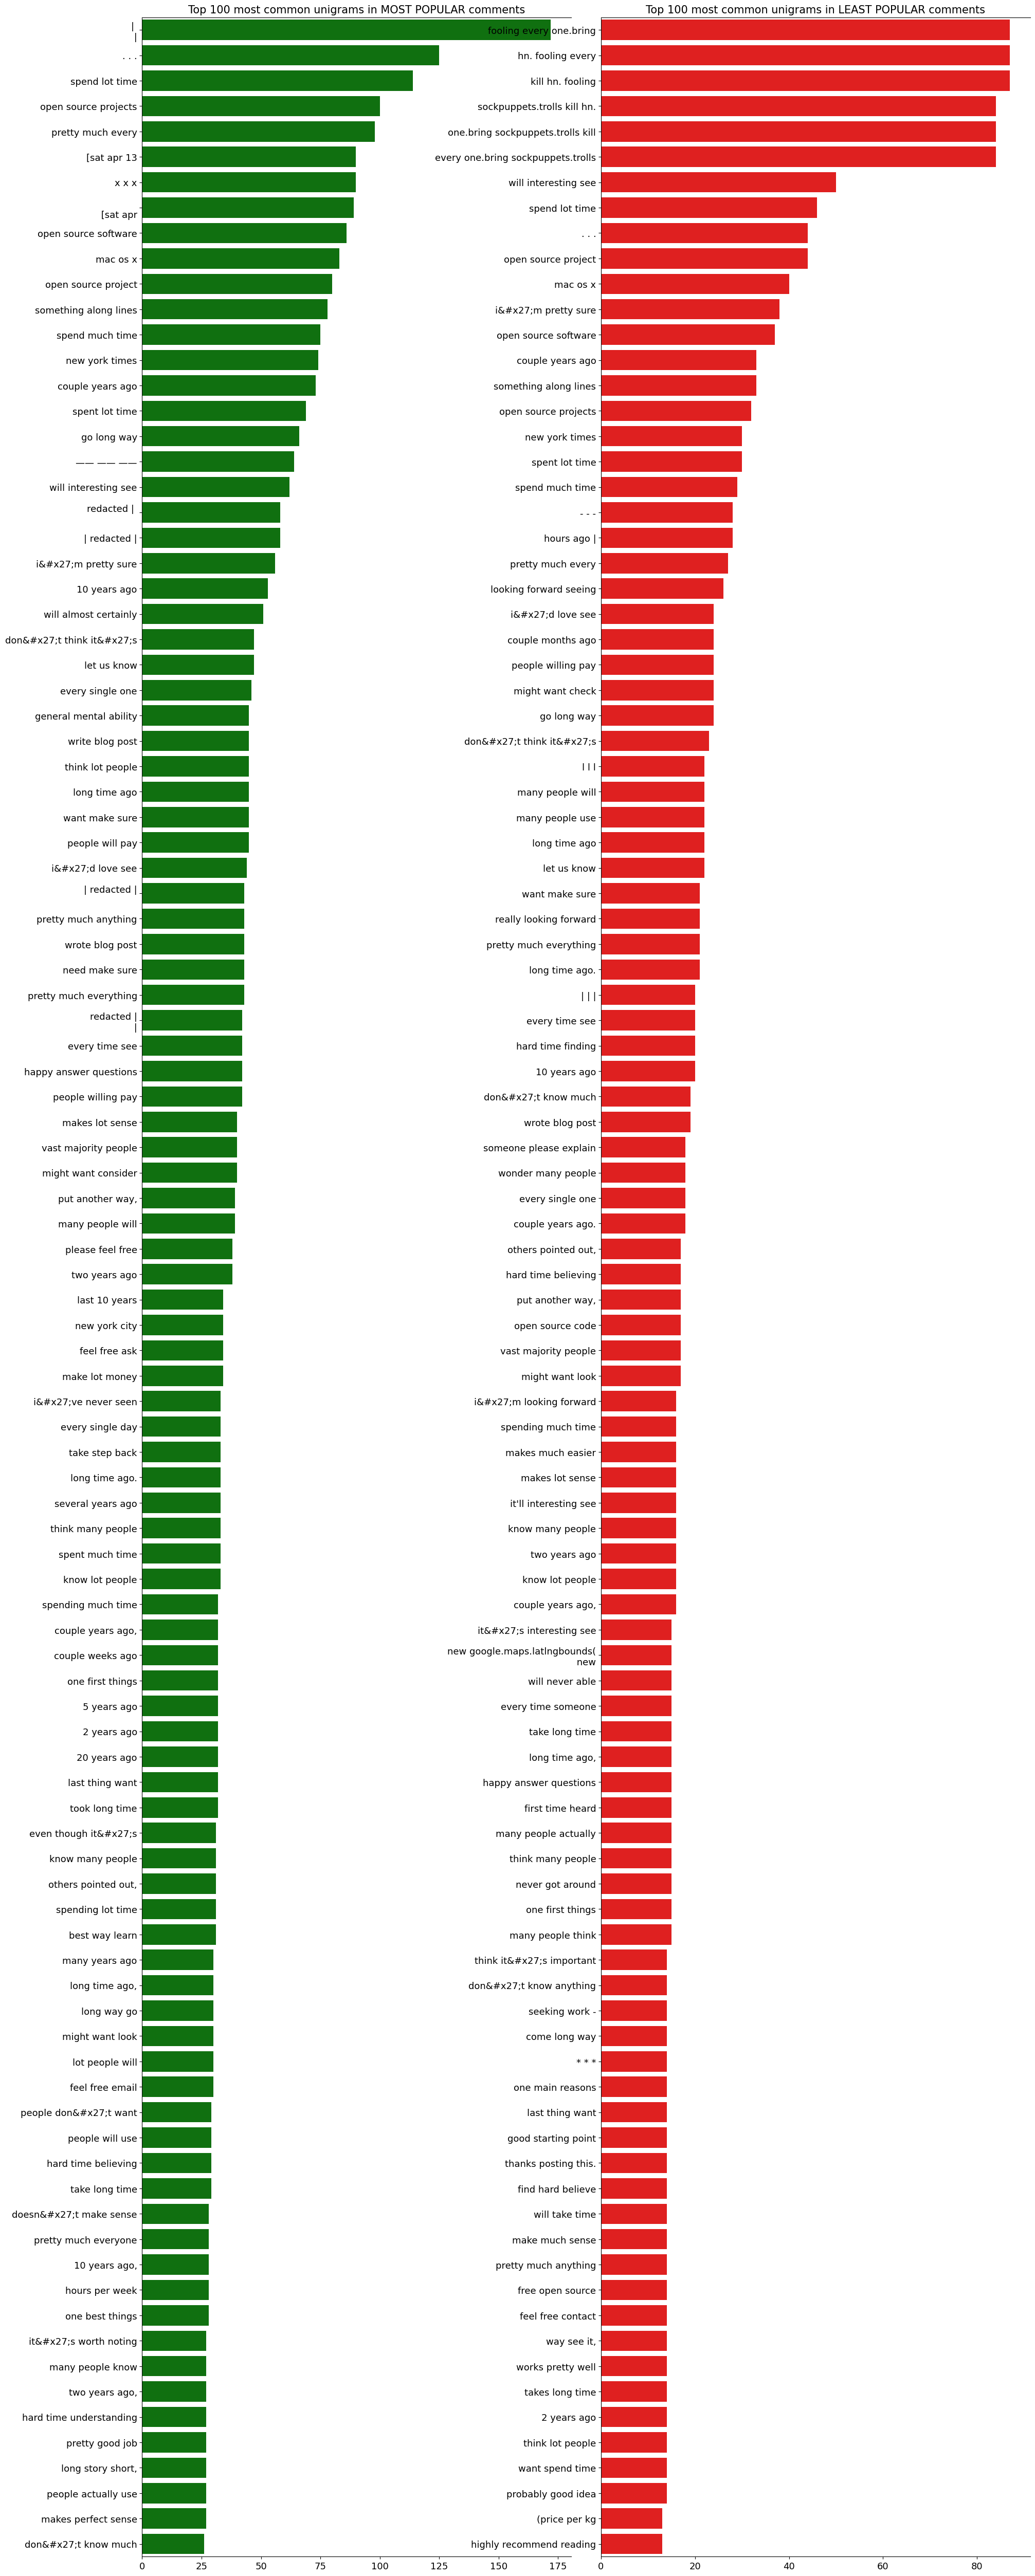

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_popular_0_trigrams[0].values[:N], x=df_popular_0_trigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_popular_4_trigrams[0].values[:N], x=df_popular_4_trigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in MOST POPULAR comments', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in LEAST POPULAR comments', fontsize=15)

plt.show()

In [37]:
values_popular = set(df_popular_0_trigrams[0].values[:N])
values_unpopular = set(df_popular_4_trigrams[0].values[:N])

Наиболее популярные уникальные слова встречающиеся в топ 100

In [38]:
values_popular - values_unpopular

{'\n [sat apr',
 '10 years ago,',
 '20 years ago',
 '5 years ago',
 '[sat apr 13',
 'best way learn',
 'couple weeks ago',
 'doesn&#x27;t make sense',
 'even though it&#x27;s',
 'every single day',
 'feel free ask',
 'feel free email',
 'general mental ability',
 'hard time understanding',
 'hours per week',
 'i&#x27;ve never seen',
 'it&#x27;s worth noting',
 'last 10 years',
 'long story short,',
 'long way go',
 'lot people will',
 'make lot money',
 'makes perfect sense',
 'many people know',
 'many years ago',
 'might want consider',
 'need make sure',
 'new york city',
 'one best things',
 'people actually use',
 'people don&#x27;t want',
 'people will pay',
 'people will use',
 'please feel free',
 'pretty good job',
 'pretty much everyone',
 'redacted |\n |',
 'redacted | \n',
 'several years ago',
 'spending lot time',
 'spent much time',
 'take step back',
 'took long time',
 'two years ago,',
 'will almost certainly',
 'write blog post',
 'x x x',
 '| \n |',
 '| redacted |',

Наименее популярные уникальные слова встречающиеся в топ 100

In [39]:
values_unpopular - values_popular

{'(price per kg',
 '* * *',
 '- - -',
 'come long way',
 'couple months ago',
 'couple years ago.',
 'don&#x27;t know anything',
 'every one.bring sockpuppets.trolls',
 'every time someone',
 'feel free contact',
 'find hard believe',
 'first time heard',
 'fooling every one.bring',
 'free open source',
 'good starting point',
 'hard time finding',
 'highly recommend reading',
 'hn. fooling every',
 'hours ago |',
 'i&#x27;m looking forward',
 'it&#x27;s interesting see',
 "it'll interesting see",
 'kill hn. fooling',
 'l l l',
 'looking forward seeing',
 'make much sense',
 'makes much easier',
 'many people actually',
 'many people think',
 'many people use',
 'might want check',
 'never got around',
 'new google.maps.latlngbounds(\n new',
 'one main reasons',
 'one.bring sockpuppets.trolls kill',
 'open source code',
 'probably good idea',
 'really looking forward',
 'seeking work -',
 'sockpuppets.trolls kill hn.',
 'someone please explain',
 'takes long time',
 'thanks posting thi

## Очистка текстов

Как мы можем заметить в наших данных очень много различного мусора, который нам необходимо почистить. Сделаем это, руководствуясь некоторыми соображениями:


*   Уберем все ссылки, так как они не вносят никакой пользы, исходя из графического анализа данных
*   Уберем знаки препинания
*   Проведем лемматизацию и стемматизацию
*   Уберем управляющие символы
*   Уберем стоп-слова



In [22]:
def cleaning(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = re.sub(r'(https?://[\S]+)', '', line)
    line = re.sub(r'\t+', '', line)

    # Contractions
    line = re.sub(r"he's", "he is", line)
    line = re.sub(r"there's", "there is", line)
    line = re.sub(r"We're", "We are", line)
    line = re.sub(r"That's", "That is", line)
    line = re.sub(r"won't", "will not", line)
    line = re.sub(r"they're", "they are", line)
    line = re.sub(r"Can't", "Cannot", line)
    line = re.sub(r"wasn't", "was not", line)
    line = re.sub(r"aren't", "are not", line)
    line = re.sub(r"isn't", "is not", line)
    line = re.sub(r"What's", "What is", line)
    line = re.sub(r"haven't", "have not", line)
    line = re.sub(r"hasn't", "has not", line)
    line = re.sub(r"There's", "There is", line)
    line = re.sub(r"He's", "He is", line)
    line = re.sub(r"It's", "It is", line)
    line = re.sub(r"You're", "You are", line)
    line = re.sub(r"I'M", "I am", line)
    line = re.sub(r"shouldn't", "should not", line)
    line = re.sub(r"wouldn't", "would not", line)
    line = re.sub(r"i'm", "I am", line)
    line = re.sub(r"I'm", "I am", line)
    line = re.sub(r"Isn't", "is not", line)
    line = re.sub(r"Here's", "Here is", line)
    line = re.sub(r"you've", "you have", line)
    line = re.sub(r"we're", "we are", line)
    line = re.sub(r"what's", "what is", line)
    line = re.sub(r"couldn't", "could not", line)
    line = re.sub(r"we've", "we have", line)
    line = re.sub(r"who's", "who is", line)
    line = re.sub(r"y'all", "you all", line)
    line = re.sub(r"would've", "would have", line)
    line = re.sub(r"it'll", "it will", line)
    line = re.sub(r"we'll", "we will", line)
    line = re.sub(r"We've", "We have", line)
    line = re.sub(r"he'll", "he will", line)
    line = re.sub(r"Y'all", "You all", line)
    line = re.sub(r"Weren't", "Were not", line)
    line = re.sub(r"Didn't", "Did not", line)
    line = re.sub(r"they'll", "they will", line)
    line = re.sub(r"they'd", "they would", line)
    line = re.sub(r"DON'T", "DO NOT", line)
    line = re.sub(r"they've", "they have", line)
    line = re.sub(r"i'd", "I would", line)
    line = re.sub(r"should've", "should have", line)
    line = re.sub(r"where's", "where is", line)
    line = re.sub(r"we'd", "we would", line)
    line = re.sub(r"i'll", "I will", line)
    line = re.sub(r"weren't", "were not", line)
    line = re.sub(r"They're", "They are", line)
    line = re.sub(r"let's", "let us", line)
    line = re.sub(r"it's", "it is", line)
    line = re.sub(r"can't", "cannot", line)
    line = re.sub(r"don't", "do not", line)
    line = re.sub(r"you're", "you are", line)
    line = re.sub(r"i've", "I have", line)
    line = re.sub(r"that's", "that is", line)
    line = re.sub(r"i'll", "I will", line)
    line = re.sub(r"doesn't", "does not", line)
    line = re.sub(r"i'd", "I would", line)
    line = re.sub(r"didn't", "did not", line)
    line = re.sub(r"ain't", "am not", line)
    line = re.sub(r"you'll", "you will", line)
    line = re.sub(r"I've", "I have", line)
    line = re.sub(r"Don't", "do not", line)
    line = re.sub(r"I'll", "I will", line)
    line = re.sub(r"I'd", "I would", line)
    line = re.sub(r"Let's", "Let us", line)
    line = re.sub(r"you'd", "You would", line)
    line = re.sub(r"It's", "It is", line)
    line = re.sub(r"Ain't", "am not", line)
    line = re.sub(r"Haven't", "Have not", line)
    line = re.sub(r"Could've", "Could have", line)
    line = re.sub(r"youve", "you have", line)  

    return line

In [23]:
prepared_train['cleaned_post_text'] = prepared_train['post_text'].apply(lambda s: cleaning(s))

In [24]:
prepared_train['cleaned_comment_text'] = prepared_train['comment_text'].apply(lambda s: cleaning(s))

In [25]:
prepared_test['cleaned_post_text'] = prepared_test['post_text'].apply(lambda s: cleaning(s))

In [26]:
prepared_test['cleaned_comment_text'] = prepared_test['comment_text'].apply(lambda s: cleaning(s))

### Добавим в качестве ещё одной фичи косинусное расстояние между парой очищенный текст поста - очищенный текст комментария. Данные вычисления были произведены в файле <Вычисление косинусного расстояния>, загрузим их оттуда

In [50]:
cousine_distances_train = torch.load('/content/drive/MyDrive/cos_sim_vec_train.pt')

In [51]:
cousine_distances_test = torch.load('/content/drive/MyDrive/cos_sim_vec_test.pt')

In [53]:
prepared_train['cosine_distances'] = cousine_distances_train

In [54]:
prepared_test['cosine_distances'] = cousine_distances_test

In [55]:
X = prepared_train.drop(columns=['post_text', 'comment_text', 'score', 'cleaned_post_text', 'cleaned_comment_text'])
y = prepared_train['score'].values

Разделим и подготовим данные

In [58]:
kf = KFold(n_splits=5)
train_indices, test_indices = kf.split(X['post_id'].unique()).__next__()

In [59]:
train_block_mask = np.isin(X.post_id, train_indices)
test_block_mask = np.isin(X.post_id, test_indices)

In [60]:
train_block = X[train_block_mask]
test_block = X[test_block_mask]
y_train = y[train_block_mask]
y_test = y[test_block_mask]

In [61]:
train_keys = train_block['post_id']
test_keys = test_block['post_id']

X_train = train_block.drop(columns=['post_id', 'comment_id'])
X_test = test_block.drop(columns=['post_id', 'comment_id'])

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
dtrain = lightgbm.Dataset(X_train_scaled, label=y_train)
dtest = lightgbm.Dataset(X_test_scaled, label=y_test)

lgbm = lightgbm.train({'num_leaves':70, 'max_depth':8}, dtrain)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1803
[LightGBM] [Info] Number of data points in the train set: 352425, number of used features: 18
[LightGBM] [Info] Start training from score 2.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [65]:
labels_predicted_lgbm = lgbm.predict(X_test_scaled)

In [70]:
@njit
def inverse_rank(arr):
  for i in range(len(arr)):
    if arr[i] == 0:
      arr[i] = 4
    elif arr[i] == 1:
      arr[i] = 3
    elif arr[i] == 3:
      arr[i] = 1
    elif arr[i] == 4:
      arr[i] = 0
  return arr

In [112]:
def nDCG_score(X_test, true_test, pred_test):
  query_uniqs = X_test['post_id'].unique()
  N = len(query_uniqs)
  summ = 0
  for i in tqdm(query_uniqs):
    cur_query_mask = X_test.post_id == i
    true_labels = true_test[cur_query_mask]
    pred_labels = pred_test[cur_query_mask]
    inv_true_labels = inverse_rank(true_labels).reshape((1, len(true_labels)))
    inv_pred_labels = inverse_rank(pred_labels).reshape((1, len(pred_labels)))
    summ += ndcg_score(inv_true_labels, inv_pred_labels)
  return summ / N

In [73]:
nDCG_score(test_block, y_test, labels_predicted_lgbm)

100%|██████████| 17622/17622 [00:17<00:00, 1026.32it/s]


0.7323522845168429

### Осуществим линейную регрессию

In [75]:
gs = GridSearchCV(Lasso(), param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}, n_jobs=-1)

gs.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]})

In [76]:
gs.best_estimator_

Lasso(alpha=0.0001)

In [77]:
linear = Lasso(alpha=0.001)
linear.fit(X_train_scaled, y_train)

Lasso(alpha=0.001)

In [78]:
pred = linear.predict(X_test_scaled)

In [79]:
nDCG_score(test_block, y_test, pred)

100%|██████████| 17622/17622 [00:15<00:00, 1136.77it/s]


0.73922841221022

### Прогоним через нейронную сеть

In [82]:
model = Sequential()
model.add(Dense(21, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='softmax'))

In [83]:
model.compile(optimizer='Adam', loss=keras.losses.MeanAbsoluteError())

In [84]:
y_train_anti_proba = y_train / 4
y_test_anti_proba = y_test / 4

In [85]:
model.fit(X_train_scaled, y_train_anti_proba)

11014/11014 [==============================] - 22s 2ms/step - loss: 0.5000


In [86]:
pred = model.predict(X_test_scaled)

2754/2754 [==============================] - 4s 1ms/step


In [87]:
nDCG_score(test_block, y_test_anti_proba, pred)

100%|██████████| 17622/17622 [00:22<00:00, 788.42it/s]


0.7617841426934926

## Исходя из полученных результатов прибегнем к нейронной сети, так как она выдала больший скор

In [95]:
X_train = prepared_train.drop(columns=['post_text', 'comment_text', 'score', 'cleaned_post_text', 'cleaned_comment_text', 'post_id', 'comment_id'])

In [113]:
y_train = prepared_train['score'].values

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [130]:
model = Sequential()
model.add(Dense(21, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='Adam', loss=keras.losses.MeanSquaredError())

In [131]:
model.fit(X_train_scaled, y_train)

13767/13767 [==============================] - 28s 2ms/step - loss: 1.8502


In [132]:
pred_train = model.predict(X_train_scaled)

13767/13767 [==============================] - 20s 1ms/step


In [147]:
nDCG_score(X, y_train, pred_train)

100%|██████████| 88107/88107 [03:38<00:00, 402.58it/s]


0.7210451657184382

In [133]:
X_test = prepared_test.drop(columns=['post_text', 'comment_text', 'score', 'cleaned_post_text', 'cleaned_comment_text', 'post_id', 'comment_id'])

In [134]:
X_test_scaled = scaler.transform(X_test)

In [135]:
pred_test = model.predict(X_test_scaled)

2189/2189 [==============================] - 3s 2ms/step


In [166]:
type(pred_test)

numpy.ndarray

### Расставим score на основе предсказаний

In [191]:
res = np.zeros(pred_test.shape)

for i in range(0, len(pred_test), 5):
  cur = pred_test[i:i+5]
  best = np.argsort(cur, axis=0)
  res[i:i+5] = best

res = np.ravel(res)

In [199]:
res[-5:]

array([1., 4., 2., 3., 0.])

## Запишем score в test датасет

In [202]:
comments_list = []

for i in range(test.shape[0]):
  comments_for_one_post = []
  
  for j in range(5):
    comments_for_one_post.append(dict({'text': prepared_test['comment_text'][i * 5 + j], 'score': res[i * 5 + j]}))
  
  comments_list.append(comments_for_one_post)


In [206]:
test['comments'] = pd.Series(comments_list)

In [210]:
test.to_json(path_or_buf='/content/drive/MyDrive/final_score')